In [1]:
import QPIXL.helper as hlp
from QPIXL.qiskit.qpixl_parallel import cFRQI
from qiskit_aer import StatevectorSimulator
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

backend = StatevectorSimulator(method="statevector")

# Bug with different sized inputs
parallel qpixl does not handle differently sized inputs well, it would be good to fix this so that images can be used arbitrarily here, there is a ```pad0``` function in ```QPIXL.helper```, but it is not implemented in the pipeline. 

In [2]:
img = Image.open("figures/creation_world.png")
img = img.convert("L")
img = np.array(
    img.resize((33, 40), Image.Resampling.LANCZOS)
)  # Compress for faster processing
img2 = Image.open("figures/cat.webp")
img2 = img2.convert("L")
img2 = np.array(img2.resize((41, 34), Image.Resampling.LANCZOS))
shapes = [
    img.shape,
    img2.shape,
]
np_frame = [np.array(img).T.flatten(), np.array(img2).T.flatten()]
decoded_data = []
labels = []
comp_str = "Compression: " + str(0) + "% \n"
qc = cFRQI(np_frame, 0)
job = backend.run(qc)
depth_str = " Circuit depth: " + str(qc.depth())
#### Just for show
sv = np.real(job.result().get_statevector())
decoded = hlp.decodeParallelQPIXL(sv, qc, len(np_frame))
for datum, shape in zip(decoded, shape):
    decoded_data.append(hlp.reconstruct_img(datum, shape))
labels.append(comp_str + depth_str)

# Plotting stuff
fig, axs = plt.subplots(2, 3, figsize=(10, 6))
for i, ax in enumerate(axs.flat):
    if i < 3:
        ax.imshow(decoded_data[i])
        ax.set_title(f"Image {i}")
        ax.axis("off")  # Hide axes
axs[1, 2].axis("off")
bottom_grid = axs[1, :2]
for i, ax in enumerate(bottom_grid):
    ax.imshow(decoded_data[i + 3])
    ax.set_title(f"Image {i + 3}")
    ax.axis("off")  # Hide axes
plt.suptitle("Decoded data", fontsize=16)
plt.tight_layout()
plt.show()

/Users/marelica/Documents/QuantumArtHack/QuantumArtHack/QPIXL/helper.py:111: RuntimeWarning: overflow encountered in scalar multiply
  scal = np.pi / (a.max() * 2)


IndexError: index 1320 is out of bounds for axis 0 with size 1320

# SOLVED - Bug with different sized inputs
See how to properly use the fixed "pad_0" function

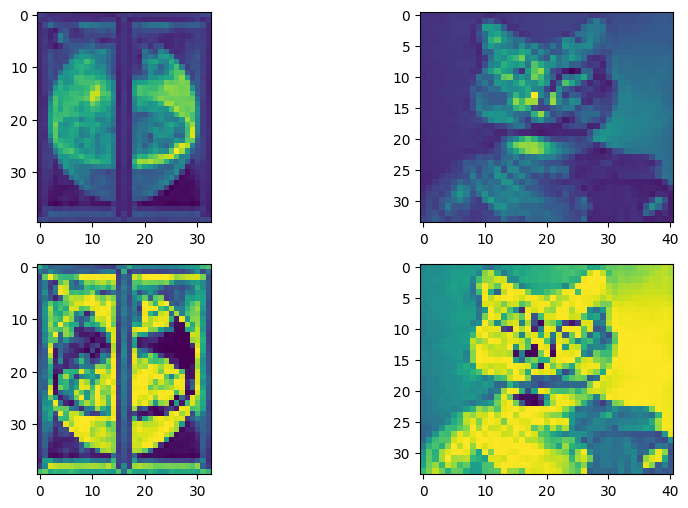

In [ ]:
# Load and resize images
img = Image.open("figures/creation_world.png")
img = img.convert("L")
img = np.array(
    img.resize((33, 40), Image.Resampling.LANCZOS)
)

img2 = Image.open("figures/cat.webp")
img2 = img2.convert("L")
img2 = np.array(img2.resize((41, 34), Image.Resampling.LANCZOS))

shapes = [
    img.shape,
    img2.shape,
]

# Plot images for reference
fig, axs = plt.subplots(2, 2, figsize=(10, 6))
axs[0][0].imshow(img)
axs[0][1].imshow(img2)

# Transpose images and pad them
padded_img = hlp.pad_0(img.T)
padded_img2 = hlp.pad_0(img2.T)

# Use padded images to build and run the circuit
np_frame = [padded_img, padded_img2]
decoded_data = []
labels = []
comp_str = "Compression: " + str(0) + "% \n"
qc = cFRQI(np_frame, 0)
job = backend.run(qc)

# Decode images without padding
sv = np.real(job.result().get_statevector())
decoded = hlp.decodeParallelQPIXL(sv, qc, len(np_frame))
for datum, shape in zip(decoded, shapes):
    decoded_data.append(hlp.reconstruct_img(datum, shape))

# Plot resulting images for comparison
axs[1][0].imshow(decoded_data[0])
axs[1][1].imshow(decoded_data[1])
